# Network Analysis for Information Retrieval - Part 1

Elyes KHALFALLAH - 52306355

31/03/2025

---

---


## 0. Etapes préliminaires


In [2]:
# Useful libraries
import nltk
import re

import numpy as np
import pandas as pd
from fonctions import *

# Downloading the necessary datasets for the nltk library
# Only download if necessary
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)


True

In [3]:
# Import data from data_project.csv
data = pd.read_csv("data_project.csv", sep="\t")

# Show the first 5 rows of the data
data.head()


,venue,abstract,authors,n_citation,references,title,year,id,class
0,international conference on human-computer int...,The purpose of this study is to develop a lear...,"['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...",0,"['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
1,visual analytics science and technology,This paper describes the design and implementa...,"['Gareth Beale', 'Graeme Earl']",50,"['10482dd3-4642-4193-842f-85f3b70fcf65', '3133...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
2,pattern recognition and machine intelligence,This article applied GARCH model instead AR or...,"['Altaf Hossain', 'Faisal Zaman', 'Mohammed Na...",50,"['2d84c0f2-e656-4ce7-b018-90eda1c132fe', 'a083...","Comparison of GARCH, Neural Network and Suppor...",2009,001c8744-73c4-4b04-9364-22d31a10dbf1,4
3,international conference on computer graphics ...,NaN,"['Rafael Álvarez', 'Leandro Tortosa', 'José-Fr...",0,NaN,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,2009,005ce28f-ed77-4e97-afdc-a296137186a1,5
4,international symposium on computer and inform...,NaN,"['Guzin Ulutas', 'Mustafa Ulutas', 'Vasif V. N...",0,"['5626736c-e434-4e2d-8405-54940fab88ab', '8e87...",Improved Secret Image Sharing Method By Encodi...,2011,00701b05-684f-45f9-b281-425abfec482c,8


---

## 1. Prétraitement des données

### 1.1. Générer le texte sur lequel nous travaillerons


In [4]:
# GET RID OF VENUE


# Fill NaN values in 'venue', 'abstract', 'title' with empty strings and create 'text'

data_text = data.fillna({"venue": "", "abstract": "", "title": ""})


# Concatenate 'venue', 'title', 'abstract' into 'text'

data_text["text"] = (

    data_text["venue"] + " " + data_text["title"] + " " + data_text["abstract"]

)


# Reposition 'text' as the first column

# data_text = data_text.drop(columns=["venue", "abstract", "title"])

cols = ["text"] + [col for col in data_text.columns if col != "text"]

data_text = data_text[cols]


# Show the first 5 rows of the cleaned data

data_text.head()


,text,venue,abstract,authors,n_citation,references,title,year,id,class
0,international conference on human-computer int...,international conference on human-computer int...,The purpose of this study is to develop a lear...,"['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...",0,"['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
1,visual analytics science and technology A meth...,visual analytics science and technology,This paper describes the design and implementa...,"['Gareth Beale', 'Graeme Earl']",50,"['10482dd3-4642-4193-842f-85f3b70fcf65', '3133...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
2,pattern recognition and machine intelligence C...,pattern recognition and machine intelligence,This article applied GARCH model instead AR or...,"['Altaf Hossain', 'Faisal Zaman', 'Mohammed Na...",50,"['2d84c0f2-e656-4ce7-b018-90eda1c132fe', 'a083...","Comparison of GARCH, Neural Network and Suppor...",2009,001c8744-73c4-4b04-9364-22d31a10dbf1,4
3,international conference on computer graphics ...,international conference on computer graphics ...,,"['Rafael Álvarez', 'Leandro Tortosa', 'José-Fr...",0,NaN,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,2009,005ce28f-ed77-4e97-afdc-a296137186a1,5
4,international symposium on computer and inform...,international symposium on computer and inform...,,"['Guzin Ulutas', 'Mustafa Ulutas', 'Vasif V. N...",0,"['5626736c-e434-4e2d-8405-54940fab88ab', '8e87...",Improved Secret Image Sharing Method By Encodi...,2011,00701b05-684f-45f9-b281-425abfec482c,8


In [5]:
# Show 'text' column of the first row
print(data_text["text"][0])


international conference on human-computer interaction Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students: Design by an Empirical Study Using a Simple Mind Map The purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net- works. More specifically, we focus on the basic principles of network proto- cols as the aim to develop our learning tool. Our tool gives students hands-on experience to help understand the basic principles of network protocols.


### 1.2. Prétrairements poussés


Now, we want to build an index for the data. To do so, we'll :

1. Remove punctuation
2. Lowercase everything
3. Remove useless spaces
4. Remove stop-words
5. Normalize the data (lemmatization)
6. Remove outliers


#### Punctuation removal :


In [6]:
# Remove all puntuation from 'text' using regex
data_text["text"] = data_text["text"].apply(lambda x: re.sub(r"[^\w\s]", " ", x))

# Show 'text' column of the first row
print(data_text["text"][0])


international conference on human computer interaction Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students  Design by an Empirical Study Using a Simple Mind Map The purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net  works  More specifically  we focus on the basic principles of network proto  cols as the aim to develop our learning tool  Our tool gives students hands on experience to help understand the basic principles of network protocols 


#### Lowercase :


In [7]:
# Convert 'text' to lowercase
data_text["text"] = data_text["text"].str.lower()

# Show 'text' column of the first row
print(data_text["text"][0])


international conference on human computer interaction preliminary design of a network protocol learning tool based on the comprehension of high school students  design by an empirical study using a simple mind map the purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net  works  more specifically  we focus on the basic principles of network proto  cols as the aim to develop our learning tool  our tool gives students hands on experience to help understand the basic principles of network protocols 


#### Spaces :


In [8]:
# Remove useless spaces using regex
data_text["text"] = data_text["text"].apply(lambda x: re.sub(r"\s+", " ", x).strip())

# Show 'text' column of the first row
print(data_text["text"][0])


international conference on human computer interaction preliminary design of a network protocol learning tool based on the comprehension of high school students design by an empirical study using a simple mind map the purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net works more specifically we focus on the basic principles of network proto cols as the aim to develop our learning tool our tool gives students hands on experience to help understand the basic principles of network protocols


Lets see what we have for now


c:\Users\elyes.khalfallah\Desktop\MALIA\NetworkAnalysis_SearchEngine\fonctions.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(plot_words), y=list(counts), palette="rainbow_r")


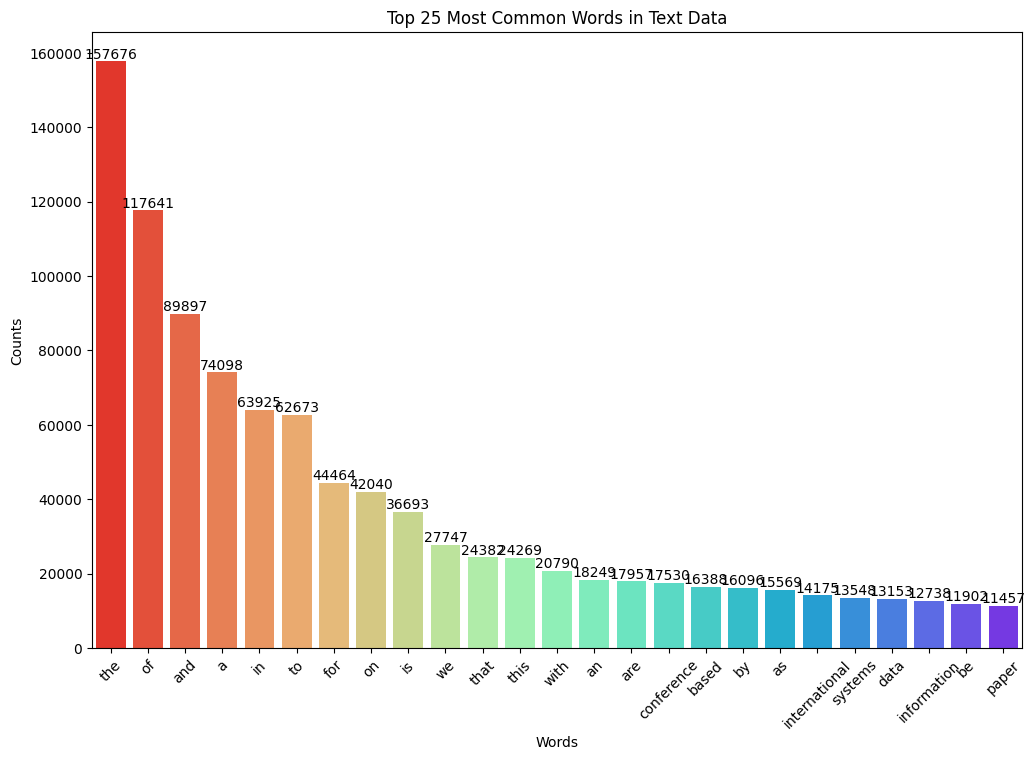

In [9]:
# Plot the most common words in the 'text' column of data_text
_ = word_occurrences(data_text, visualisation=True)


#### Stop-words :


In [10]:
# Remove stop words from 'text' column in data_text
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
data_text["text"] = data_text["text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)


c:\Users\elyes.khalfallah\Desktop\MALIA\NetworkAnalysis_SearchEngine\fonctions.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(plot_words), y=list(counts), palette="rainbow_r")


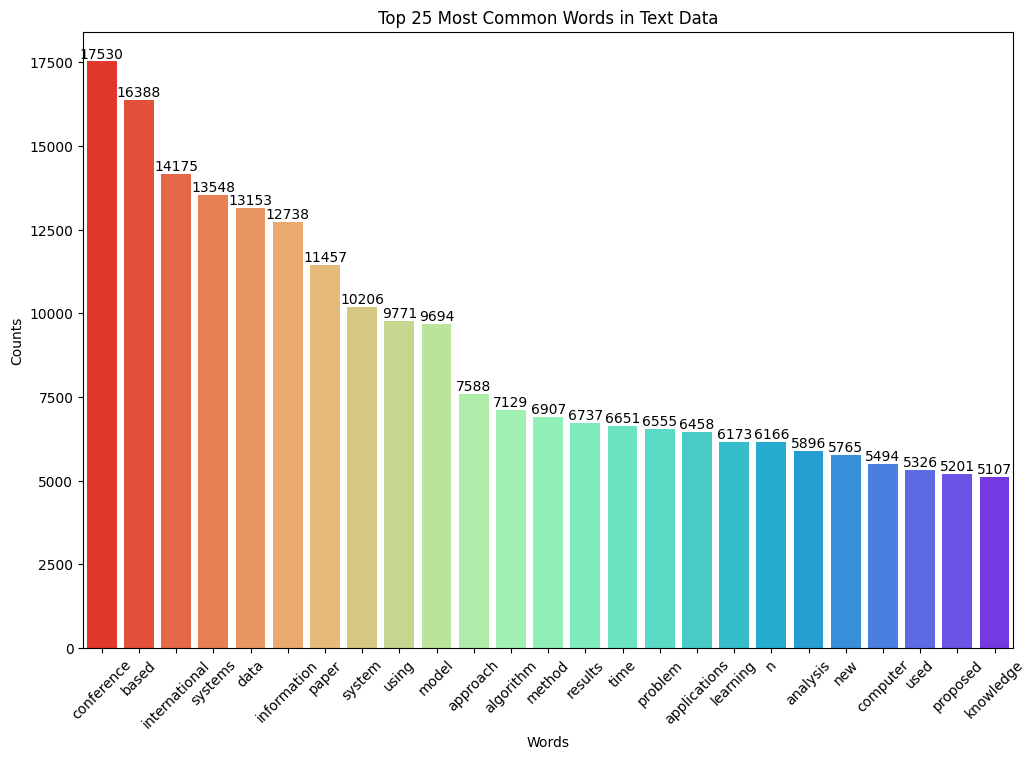

In [11]:
# Plot the most common words in the 'text' column of data_text
_ = word_occurrences(data_text, visualisation=True)


#### Normalize data (lemming) :


In [12]:
# Imports for lemmatization
from nltk.stem import WordNetLemmatizer

# Define lemmatizer tool
lemmatizer = WordNetLemmatizer()

# Show the first row to verify the lemmatization
print("Before :\n\t", data_text["text"][0])

# Apply lemmatization to each word in the text
data_text["text"] = data_text["text"].apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()])
)

# Show the first row to verify the lemmatization
print("After :\n\t", data_text["text"][0])


Before :
	 international conference human computer interaction preliminary design network protocol learning tool based comprehension high school students design empirical study using simple mind map purpose study develop learning tool high school students studying scientific aspects information communication net works specifically focus basic principles network proto cols aim develop learning tool tool gives students hands experience help understand basic principles network protocols
After :
	 international conference human computer interaction preliminary design network protocol learning tool based comprehension high school student design empirical study using simple mind map purpose study develop learning tool high school student studying scientific aspect information communication net work specifically focus basic principle network proto col aim develop learning tool tool give student hand experience help understand basic principle network protocol


c:\Users\elyes.khalfallah\Desktop\MALIA\NetworkAnalysis_SearchEngine\fonctions.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(plot_words), y=list(counts), palette="rainbow_r")


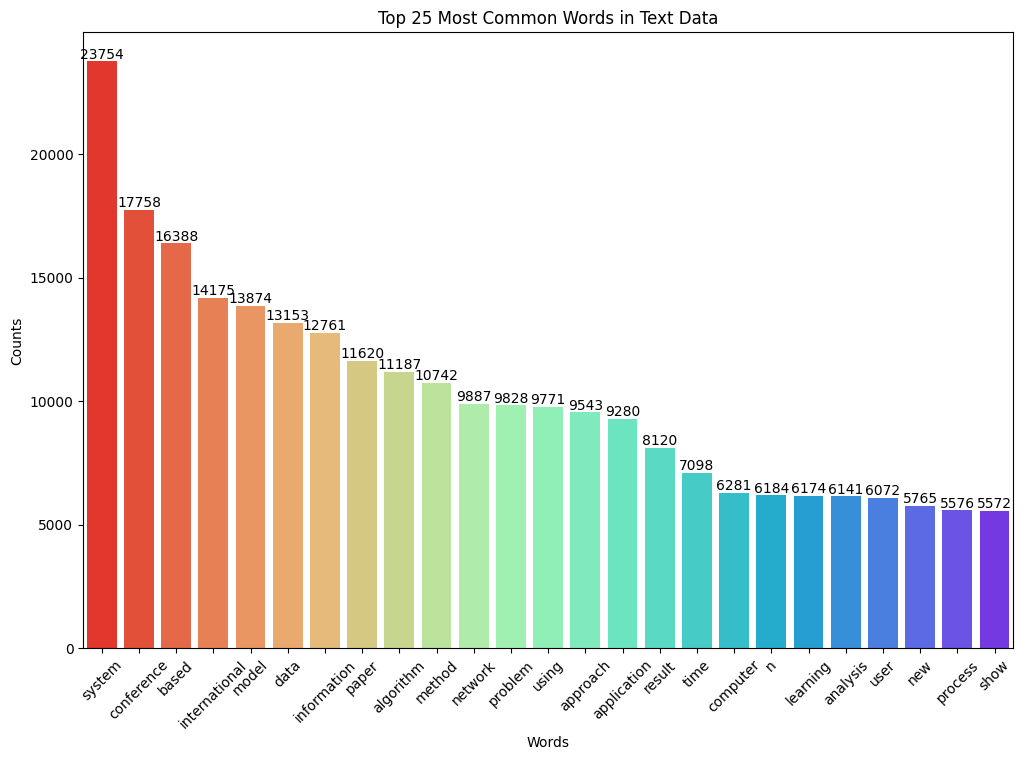

In [13]:
# Plot the most common words after lemmatization
_ = word_occurrences(data_text, visualisation=True)


#### Remove outliers :


C:\Users\elyes.khalfallah\AppData\Local\Temp\ipykernel_8040\499328142.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(list(word_occurrences(data_text).values()), palette="rainbow_r")


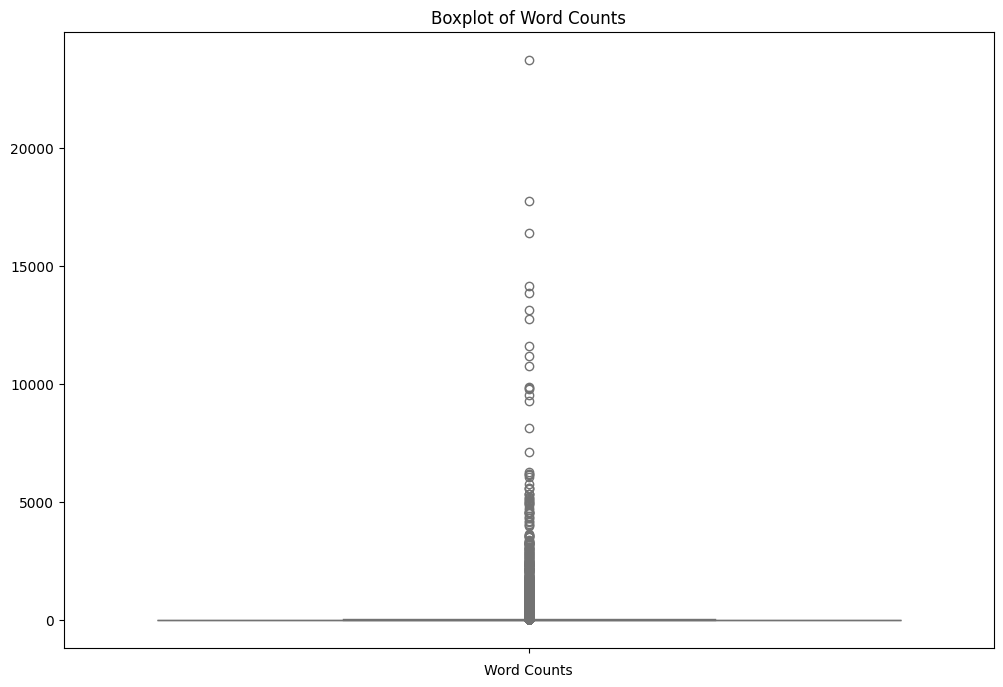

In [14]:
# See if there are outliers in occurrences
plt.figure(figsize=(12, 8))
sns.boxplot(list(word_occurrences(data_text).values()), palette="rainbow_r")
plt.xlabel("Word Counts")
plt.title("Boxplot of Word Counts")
plt.show()


In [15]:
# occurrences = word_occurrences(data_text)

# # Define limits as 10th and 90th percentiles
# min_occurrences = pd.Series(occurrences).quantile(0.825)
# max_occurrences = pd.Series(occurrences).quantile(0.955)
# print("Min occurrences:", min_occurrences)
# print("Max occurrences:", max_occurrences)

# # Identify words that have more than max_occurrences occurrences
# high_outliers = {
#     word: count for word, count in occurrences.items() if count > max_occurrences
# }

# # Identify words that have less than min_occurrences occurrences
# low_outliers = {
#     word: count for word, count in occurrences.items() if count < min_occurrences
# }

# # print("High outliers:", high_outliers)
# # print("Low outliers:", low_outliers)

# # Remove words that are in high_outliers and low_outliers from 'text' column in data_text
# data_text["text"] = data_text["text"].apply(
#     lambda x: " ".join(
#         [
#             word
#             for word in x.split()
#             if word not in high_outliers and word not in low_outliers
#         ]
#     )
# )


In [16]:
# before = len(occurrences)
# after = len(word_occurrences(data_text))
# difference = before - after

# print("Number of words before removing outliers :", before)
# print("Number of words after removing outliers  :", after)
# print("Difference (amount of words removed)     :", difference)


C:\Users\elyes.khalfallah\AppData\Local\Temp\ipykernel_8040\499328142.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(list(word_occurrences(data_text).values()), palette="rainbow_r")


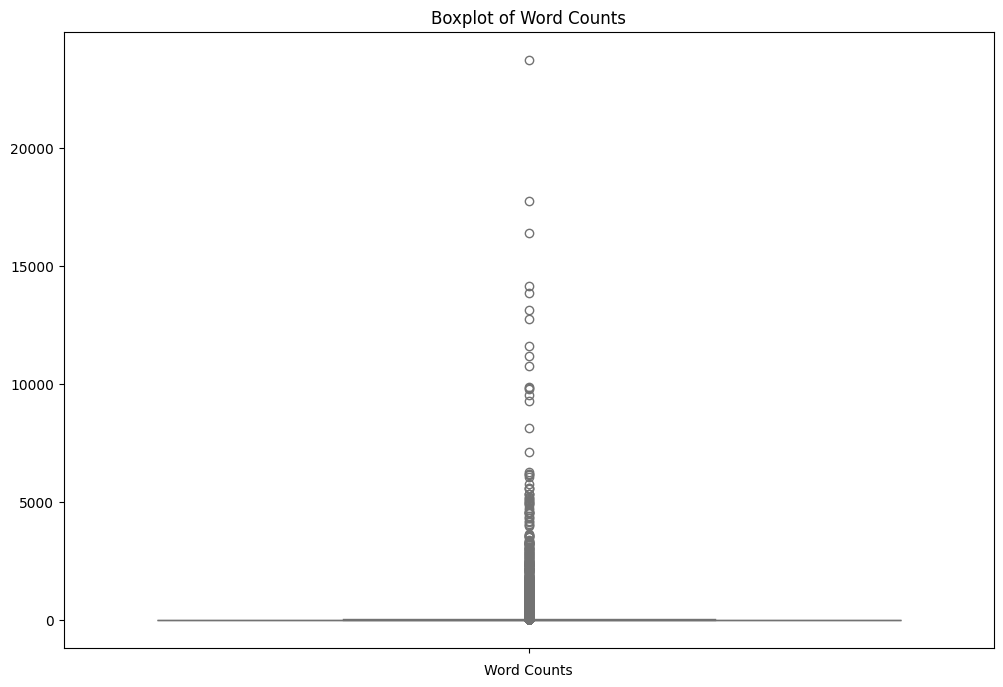

In [17]:
# See if there are outliers in occurrences
plt.figure(figsize=(12, 8))
sns.boxplot(list(word_occurrences(data_text).values()), palette="rainbow_r")
plt.xlabel("Word Counts")
plt.title("Boxplot of Word Counts")
plt.show()


c:\Users\elyes.khalfallah\Desktop\MALIA\NetworkAnalysis_SearchEngine\fonctions.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(plot_words), y=list(counts), palette="rainbow_r")


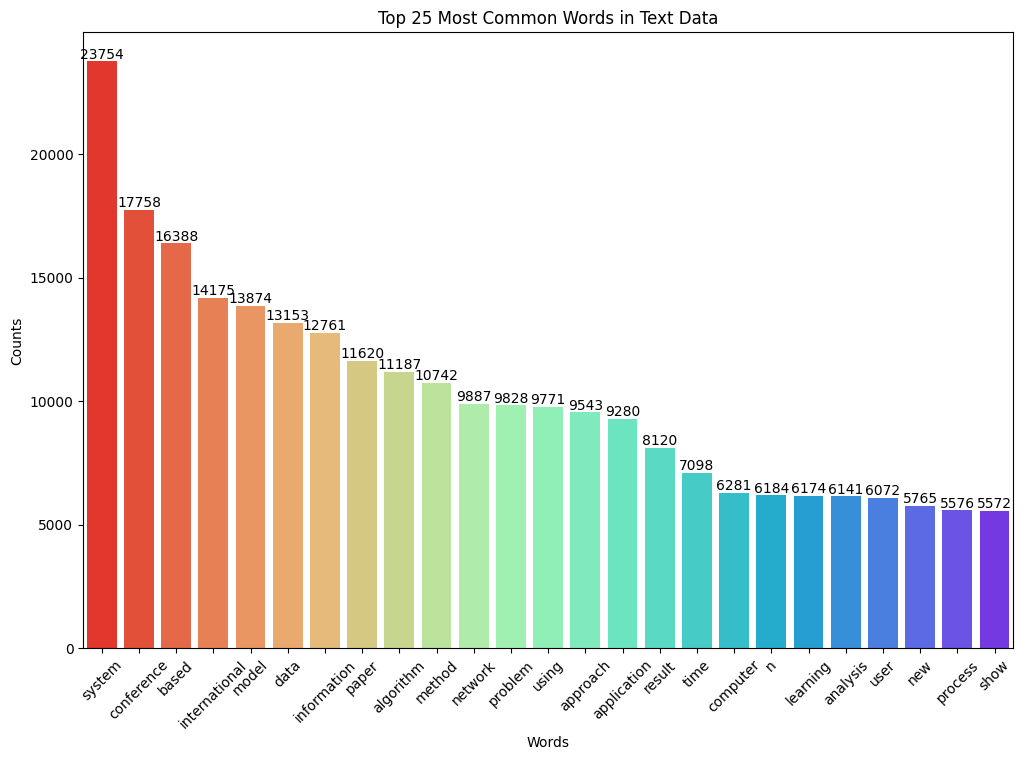

In [18]:
clean_word_counts = word_occurrences(data_text, visualisation=True)


---

## 2. Mise en place du moteur de recherche


In [19]:
# Nous allons maintenant construire la matrice Documents x Termes en adoprant le schéma de pondération TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the 'text' column
X = vectorizer.fit_transform(data_text["text"])

# Show the shape of the resulting matrix
X.shape


(40596, 55614)

shape de l'embedding (1000, 3)


c:\Users\elyes.khalfallah\Desktop\MALIA\NetworkAnalysis_SearchEngine\env_netanalysis\lib\site-packages\matplotlib\collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


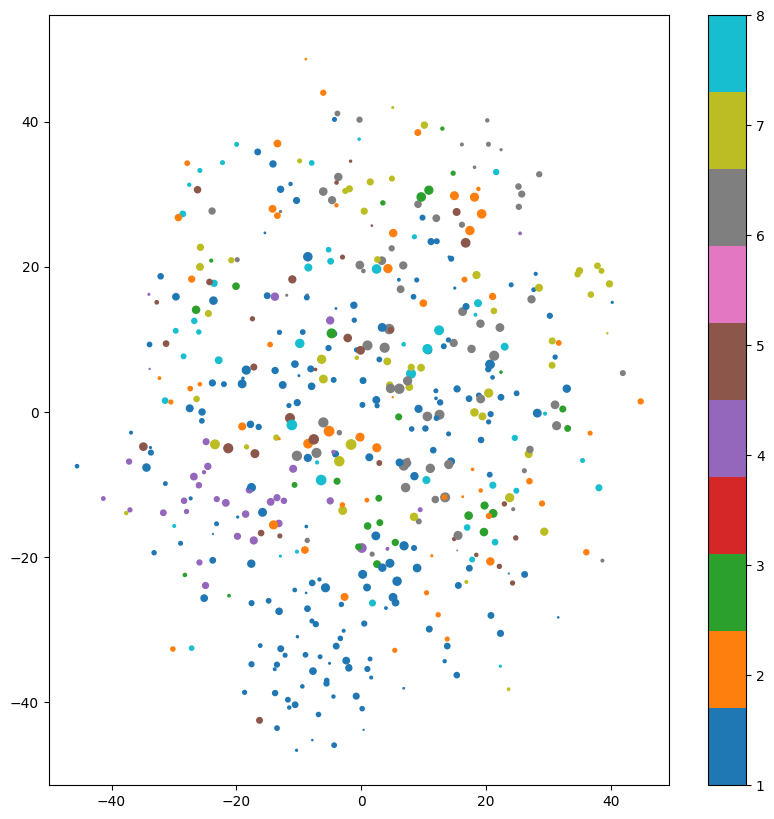

In [ ]:
from sklearn.manifold import TSNE
# visualiser TFIDF

tsne_transform = TSNE(n_components=3, random_state=42)
X_embedded = tsne_transform.fit_transform(X[:1000].toarray())
print(f"shape de l'embedding {X_embedded.shape}")
plt.figure(figsize=(10, 10))    
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=data_text[:1000]["class"], cmap="tab10")
plt.colorbar()
plt.show()


In [31]:
requete = ["representation", "learning", "for", "natural", "language", "processing"]

pseudo_document = vectorizer.transform([" ".join(requete)])

# Calculer les similarités cosinus entre le pseudo-document et les documents
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(X, pseudo_document)

# Afficher les 5 documents les plus similaires
top5_idx = np.argsort(similarities.flatten())[::-1][:5]
print(top5_idx)

# Afficher les titres des 5 documents les plus similaires
print(data_text.iloc[top5_idx]["text"])


[11779 14285 11973    45  1022]
11779    computational learning theory unsupervised lea...
14285    international conference computational linguis...
11973    empirical method natural language processing d...
45       recent advance natural language processing nea...
1022     new trend software methodology tool technique ...
Name: text, dtype: object
